<a href="https://colab.research.google.com/github/JanMarcelKezmann/Residual-Network-Architectures/blob/master/Residual_Network_101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import tensorflow as tf

from tensorflow.keras.layers import Input, Add, Dense, Flatten, Activation, BatchNormalization, Conv2D, ZeroPadding2D, AveragePooling2D
from tensorflow.keras.models import Model, save_model, load_model
from tensorflow.keras.initializers import glorot_uniform
import tensorflow.keras.backend as K

K.set_image_data_format("channels_last")
K.set_learning_phase(1)

from IPython.display import SVG
from matplotlib.pyplot import imshow
%matplotlib inline

# Create all Building Blocks

## Identity Block

In [0]:
def identity_block(X, f, filters, stage, block):
    conv_name_base = "res" + str(stage) + block + "_branch"
    bn_name_base = "bn" + str(stage) + block + "_branch"

    # Filters
    F1, F2, F3 = filters

    # Save the input value as Shortcut
    X_shortcut = X

    # Main Path
    # First Component of Main Path
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding="valid", name=conv_name_base + "2a", kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + "2a")(X)
    X = Activation("relu")(X)

    # Second Component of Main Path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding="same", name=conv_name_base + "2b", kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + "2b")(X)
    X = Activation("relu")(X)

    # Third Component of Main Path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding="valid", name=conv_name_base + "2c", kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + "2c")(X)
    X = Activation("relu")(X)

    # Final Step: Add the Shortcut to the Main Path
    X = Add()([X, X_shortcut])
    X = Activation("relu")(X)

    return X

## Convolutional Block

In [0]:
def convolutional_block(X, f, filters, stage, block, strides=2):
    conv_name_base = "res" + str(stage) + block + "_branch"
    bn_name_base = "bn" + str(stage) + block + "_branch"

    # Filters
    F1, F2, F3 = filters

    # Save input value as shortcut
    X_shortcut = X

    # Main Path
    # First Component of Main Path
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(strides, strides), padding="valid", name=conv_name_base + "2a", kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + "2a")(X)
    X = Activation("relu")(X)

    # Second Component of Main Path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding="same", name=conv_name_base + "2b", kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + "2b")(X)
    X = Activation("relu")(X)

    # Third Component of Main Path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding="valid", name=conv_name_base + "2c", kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + "2c")(X)
    X = Activation("relu")(X)

    # Shortcut Path
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(strides, strides), padding="valid", name=conv_name_base + "1", kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + "1")(X_shortcut)

    # Final Step: Add shortcut path to main path
    X = Add()([X_shortcut, X])
    X = Activation("relu")(X)

    return X

In [0]:
# tf.reset_default_graph()

# with tf.Session() as sess:
#     np.random.seed(1)
#     A_prev = tf.placeholder("float", [3, 4, 4, 6])
#     X = np.random.randn(3, 4, 4, 6)
#     A = identity_block(A_prev, f=3, filters=[2, 4, 6], stage=1, block="a")
#     sess.run(tf.global_variables_initializer())

#     out = sess.run([A], feed_dict={A_prev: X, K.learning_phase(): 0})
#     print("out = " + str(out[0][0][0][0]))
#     print(np.size(out))

## ResNet 101

In [0]:
def ResNet101(input_shape=(224, 224, 3), classes=100):
    # Define Input as tensor with input_shape as shape
    # Default shape: (224x224x3)
    X_input = Input(input_shape)

    # ZeroPadding2D(((7 - 1) / 2, (7 - 1) / 2))(X_input)
    # Output shape: (230x230x3)
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    # Output shape after Conv2D: (112x112x64)
    X = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), name="conv1", kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name="bn_conv1")(X)
    X = Activation("relu")(X)
    
    # Output shape after MaxPooling2D: (56x56x64)
    X = MaxPooling2D((3, 3), strides=(2, 2), padding="same")(X)

    # Stage 2
    # Output shape after stage 2: (56x56x256)
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block="a", strides=1)
    X = identity_block(X, f=3, filters=[64, 64, 256], stage=2, block="b")
    X = identity_block(X, f=3, filters=[64, 64, 256], stage=2, block="c")
    
    # Stage 3
    # Output shape after stage 3: (28x28x512)
    X = convolutional_block(X, f=4, filters=[128, 128, 512], stage=3, block="a", strides=2)
    X = identity_block(X, f=4, filters=[128, 128, 512], stage=3, block="b")
    X = identity_block(X, f=4, filters=[128, 128, 512], stage=3, block="c")
    X = identity_block(X, f=4, filters=[128, 128, 512], stage=3, block="d")

    # Stage 4
    # Output shape after stage 4: (14x14x1024)
    X = convolutional_block(X, f=6, filters=[256, 256, 1024], stage=4, block="a", strides=2)
    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="b")
    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="c")
    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="d")
    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="e")
    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="f")
    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="g")
    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="h")
    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="i")
    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="j")

    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="k")
    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="l")
    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="m")
    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="n")
    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="o")
    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="p")
    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="q")
    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="r")
    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="s")
    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="t")

    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="u")
    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="v")
    X = identity_block(X, f=6, filters=[256, 256, 1024], stage=4, block="w")

    # Stage 5
    # Output shape after stage 5: (7x7x2048)
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block="a", strides=2)
    X = identity_block(X, f=3, filters=[512, 512, 2048], stage=5, block="b")
    X = identity_block(X, f=3, filters=[512, 512, 2048], stage=5, block="c")

    # Final Stage
    # Output shape after Dense Layer: (classes)
#     X = AveragePooling2D((2, 2), name="avg_pool")(X)
    X = Flatten()(X)
    X = Dense(classes, activation="softmax", name="fc" + str(classes), kernel_initializer=glorot_uniform(seed=0))(X)

    # Create Model
    model = Model(inputs=X_input, outputs=X, name="ResNet101")

    return model

In [26]:
model = ResNet101()
model.summary()

Model: "ResNet101"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_7 (ZeroPadding2D (None, 230, 230, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        zero_padding2d_7[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________

In [0]:
def random_mini_batches(X, y, mini_batch_size=32, seed=0):
    m = X.shape[0]
    mini_batches = []
    np.random.seed(seed)

    # Step 1: shuffle (X, y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation, :, :, :]
    shuffled_y = X[permutation, :]

    # Step 2: partition (shuffled_X, shuffled_y)
    num_complete_minibatches = math.floor(m / mini_batch_size)
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size:(k + 1) * mini_batch_size, :, :, :]
        mini_batch_y = shuffled_y[k * mini_batch_size:(k + 1) * mini_batch_size, :]
        mini_batch = (mini_batch_X, mini_batch_y)
        mini_batches.append(mini_batch)

    # handling the rest case
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size:m, :, :, :]
        mini_batch_y = shuffled_y[num_complete_minibatches * mini_batch_size:m, :]
        mini_batch = (mini_batch_X, mini_batch_y)
        mini_batches.append(mini_batch)

    return mini_batches

In [0]:
def convert_to_one_hot(y, classes):
    y = np.eye(int(classes))[y.reshape(-1)].T
    return y

In [0]:
def forward_prop_for_pred(X, params):
    # Retrieve the parameters from the dictionairy "parameters"
    W1 = params["W1"]
    b1 = params["b1"]
    W2 = params["W2"]
    b2 = params["b2"]
    W3 = params["W3"]
    b3 = params["b3"]

    Z1 = tf.add(tf.matmul(W1, X), b1)
    A1 = tf.nn.relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)
    A2 = tf.nn.relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)

    return Z3

In [0]:
def predict(X, parameters):
    m = X.shape()
    W1 = tf.convert_to_tensor(params["W1"])
    b1 = tf.convert_to_tensor(params["b1"])
    W2 = tf.convert_to_tensor(params["W2"])
    b2 = tf.convert_to_tensor(params["b2"])
    W3 = tf.convert_to_tensor(params["W3"])
    b3 = tf.convert_to_tensor(params["b3"])

    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3": b3}

    var = tf.placeholder("float", [m, 1])

    z3 = forward_prop_for_pred(X, params)
    p = tf.argmax(z3)

    sess = tf.Session()
    prediction = sess.run(p, feed_dict={x: X})

    return prediction

In [0]:
from tensorflow.keras.datasets import cifar100, mnist

(X_train_cifar100, y_train_cifar100), (X_test_cifar100, y_test_cifar100) = cifar100.load_data()
print(X_train_cifar100.shape)
print(X_test_cifar100.shape)

(X_train_mnist, y_train_mnist), (X_test_mnist, y_test_mnist) = mnist.load_data()
X_train_mnist = X_train_mnist.reshape(60000, 28, 28, -1)
X_test_mnist = X_test_mnist.reshape(10000, 28, 28, -1)
print(X_train_mnist.shape)
print(X_test_mnist.shape)

169009152/169001437 [==============================] - 6s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)
11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [0]:
model_cifar100 = ResNet101(input_shape=(32, 32, 3), classes=100)
model_cifar100.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model_mnist = ResNet101(input_shape=(28, 28, 1), classes=10)
model_mnist.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

(?, 38, 38, 3)
(?, 34, 34, 1)


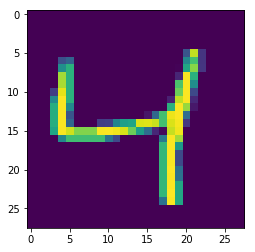

In [0]:
imshow(X_train_mnist[2].reshape(28, 28))

In [0]:
# normalize image vectors
X_train_cifar100 = X_train_cifar100 / 255.0
X_test_cifar100 = X_test_cifar100 / 255.0

# convert training and test labels to one hot encoded matrices
y_train_cifar100 = convert_to_one_hot(y_train_cifar100, 100).T
y_test_cifar100 = convert_to_one_hot(y_test_cifar100, 100).T

print("number of training examples = " + str(X_train_cifar100.shape[0]))
print("number of test examples = " + str(X_test_cifar100.shape[0]))
print("X_train shape: " + str(X_train_cifar100.shape))
print("y_train shape: " + str(y_train_cifar100.shape))
print("X_test shape: " + str(X_test_cifar100.shape))
print("y_test shape: " + str(y_test_cifar100.shape))

number of training examples = 50000
number of test examples = 10000
X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 100)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 100)


In [0]:
model_cifar100.fit(X_train_cifar100, y_train_cifar100, epochs=20, batch_size=50)
predictions = model_cifar100.evaluate(X_test_cifar100, y_test_cifar100)

print("Loss: " + str(predictions[0]))
print("Test Accuracy " + str(predictions[1]))

Epoch 1/20
50000/50000 [==============================] - 382s 8ms/sample - loss: 4.7276 - acc: 0.0935
Epoch 2/20
50000/50000 [==============================] - 384s 8ms/sample - loss: 4.3362 - acc: 0.1112
Epoch 3/20
50000/50000 [==============================] - 382s 8ms/sample - loss: 3.9726 - acc: 0.1378
Epoch 4/20
50000/50000 [==============================] - 383s 8ms/sample - loss: 3.7864 - acc: 0.1625
Epoch 5/20
50000/50000 [==============================] - 384s 8ms/sample - loss: 3.7185 - acc: 0.1714
Epoch 6/20
50000/50000 [==============================] - 382s 8ms/sample - loss: 3.3853 - acc: 0.2039
Epoch 7/20
50000/50000 [==============================] - 380s 8ms/sample - loss: 3.1764 - acc: 0.2330
Epoch 8/20
50000/50000 [==============================] - 381s 8ms/sample - loss: 2.9929 - acc: 0.2573
Epoch 9/20
50000/50000 [==============================] - 380s 8ms/sample - loss: 2.9636 - acc: 0.2595
Epoch 10/20
50000/50000 [==============================] - 380s 8ms/sampl

In [0]:
model_cifar100.summary()

Model: "ResNet101"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________

In [0]:
# normalize image vectors
X_train_mnist = X_train_mnist / 255.0
X_test_mnist = X_test_mnist / 255.0

# convert training and test labels to one hot encoded matrices
y_train_mnist = convert_to_one_hot(y_train_mnist, 10).T
y_test_mnist = convert_to_one_hot(y_test_mnist, 10).T

print ("number of training examples = " + str(X_train_mnist.shape[0]))
print ("number of test examples = " + str(X_test_mnist.shape[0]))
print ("X_train shape: " + str(X_train_mnist.shape))
print ("Y_train shape: " + str(y_train_mnist.shape))
print ("X_test shape: " + str(X_test_mnist.shape))
print ("Y_test shape: " + str(y_test_mnist.shape))

number of training examples = 60000
number of test examples = 10000
X_train shape: (60000, 28, 28, 1)
Y_train shape: (60000, 10)
X_test shape: (10000, 28, 28, 1)
Y_test shape: (10000, 10)


In [0]:
model_mnist.fit(X_train_mnist, y_train_mnist, epochs=20, batch_size=50)
predictions = model_mnist.evaluate(X_test_mnist, y_test_mnist)

print("Loss: " + str(predictions[0]))
print("Test Accuracy: " + str(predictions[1]))

Epoch 1/20
60000/60000 [==============================] - 462s 8ms/sample - loss: 0.5008 - acc: 0.8727
Epoch 2/20
60000/60000 [==============================] - 451s 8ms/sample - loss: 0.2075 - acc: 0.9504
Epoch 3/20
60000/60000 [==============================] - 451s 8ms/sample - loss: 0.3006 - acc: 0.9414
Epoch 4/20
60000/60000 [==============================] - 451s 8ms/sample - loss: 0.1534 - acc: 0.9636
Epoch 5/20
60000/60000 [==============================] - 451s 8ms/sample - loss: 0.1561 - acc: 0.9611
Epoch 6/20
60000/60000 [==============================] - 451s 8ms/sample - loss: 0.1698 - acc: 0.9648
Epoch 7/20
60000/60000 [==============================] - 451s 8ms/sample - loss: 0.1691 - acc: 0.9636
Epoch 8/20
60000/60000 [==============================] - 451s 8ms/sample - loss: 0.0757 - acc: 0.9788
Epoch 9/20
60000/60000 [==============================] - 448s 7ms/sample - loss: 0.0657 - acc: 0.9831
Epoch 10/20
60000/60000 [==============================] - 449s 7ms/sampl

In [0]:
model_mnist.summary()

Model: "ResNet101"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 34, 34, 1)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 14, 14, 64)   3200        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 14, 14, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________